## 19대 대선 결과 분석
* selenium과 Beautiful Soup이용하여 데이터 획즉 준비 작업

In [173]:
import pandas as pd
import numpy as np

import platform

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import font_manager, rc

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system. sorry~~~')

plt.rcParams['axes.unicode_minus'] = False

### 중앙선거관리위원회 선거통계시스템
* 메인화면에서 역대선거 클릭 - 투개표 - 개표현황 - 개표현황 페이지 주소

In [174]:
from selenium import webdriver
import time

In [175]:
driver = webdriver.Chrome('../driver/chromedriver')
driver.get('http://info.nec.go.kr/main/showDocument.xhtml?electionId=0000000000&topMenuId=VC&secondMenuId=VCCP09')

In [177]:
# 대통령선거
driver.find_element_by_xpath('''//*[@id="electionType1"]''').click()
# driver.find_element_id('electionType1').click()    - selector

In [178]:
# 19대 선택
driver.find_element_by_id('electionName').send_keys('제19대')

In [179]:
driver.find_element_by_id('electionCode').send_keys('대통령선거')

In [180]:
sido_list_raw = driver.find_element_by_xpath('''//*[@id="cityCode"]''')
sido_list = sido_list_raw.find_elements_by_tag_name('option')

In [181]:
sido_names_values = [option.text for option in sido_list]
sido_names_values = sido_names_values[2:]
sido_names_values

['서울특별시',
 '부산광역시',
 '대구광역시',
 '인천광역시',
 '광주광역시',
 '대전광역시',
 '울산광역시',
 '세종특별자치시',
 '경기도',
 '강원도',
 '충청북도',
 '충청남도',
 '전라북도',
 '전라남도',
 '경상북도',
 '경상남도',
 '제주특별자치도']

## 지역을 선택하면 나타나는 화면중 하나인데 득표수에 득표율이 괄호로() 함께 나타남
## 이를 제거하고 (*를 기준으로 왼쪽 숫자만 얻어서, 콤마(,)를 제거하고, float형으로 변경하는 함수 *get_num으로 준비해줌.

In [182]:
import re
def get_num(tmp):
    return float(re.split('\(',tmp)[0].replace(',',''))

In [183]:
tmp = '한국3,000'
re.split('\(',tmp)[0].replace(',','')

'한국3000'

### 책에서는 특별히 다루고 있지 않지만, 아래 모듈을 import해서 wait.until 함수를 사용할 수 있음.
### http://selenium-python.readthedocs.io/waits.html
### 페이지 로딩 시간을 기다린 후 크롤링 하기
### 몇몇 페이지의 경우, 페이지 로딩 지연이 발생하여 tag를 못 읽어노는 경우가 발생.
### 이때, 아래의 코드를 이용하여 해결 가능
### 이 함수는 검색 버튼이 클릭 가능할때 까지 기다리는 기능을 합니다.
### 

In [184]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

wait = WebDriverWait(driver, 10)
#시간을 더주고 싶으면 변수 넘버 바꿔준다.

def move_sido(name):
    element = driver.find_element_by_id("cityCode")
    element.send_keys(name)
    make_xpath = '''//*[@id="searchBtn"]'''
    #xpath 속성이 make_xpath인 
    
     # xpath 속성이 make_xpath인 element가 리턴될 때까지 10초간 기다린다.
    # 만약 10초전에 page가 로딩되고 element가 실행된다면 EC 또는 true를 반환한다.
    wait.until(EC.element_to_be_clickable((By.XPATH, make_xpath)))
    driver.find_element_by_xpath(make_xpath).click()

* Explicit Waits 특정 상태가 될때까지 기다리고, 상태가 되면 바로 실행한다.
* append_data 함수는 빈 내용으로 미리 준비한 dataframe에 원하는 형태로 append 해준다. 

In [185]:
def append_data(df, sido_name, data):
    for each in df[0].values[1:]:
        data['광역시도'].append(sido_name)
        data['시군'].append(each[0])
        data['pop'].append(float(each[2]))
        data['moon'].append(get_num(each[3]))
        data['hong'].append(get_num(each[4]))
        data['ahn'].append(get_num(each[5]))

In [186]:
election_result_raw = {'광역시도':[],
                      '시군':[],
                      'pop':[],
                      'moon':[],
                      'hong':[],
                      'ahn':[]}

In [187]:
from bs4 import BeautifulSoup
for each_sido in sido_names_values:
    move_sido(each_sido)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find('table')
    df = pd.read_html(str(table))
    append_data(df, each_sido, election_result_raw)

In [188]:
df

[       구시군명     선거인수     투표수   후보자별 득표수(득표율)          무효투표수            기권수  \
   더불어민주당문재인 자유한국당홍준표 국민의당안철수         바른정당유승민         정의당심상정        새누리당조원진   
 0        합계   518000  374459  169,493(45.51)  68,063(18.27)  77,861(20.90)   
 1       제주시   375292  273163  125,717(46.25)  48,027(17.67)  55,971(20.59)   
 2      서귀포시   142708  101296   43,776(43.50)  20,036(19.91)  21,890(21.75)   
 
   Unnamed: 6_level_0 Unnamed: 7_level_0 Unnamed: 8_level_0 Unnamed: 9_level_0  \
             경제애국당오영국          국민대통합당장성민          늘푸른한국당이재오           민중연합당김선동   
 0       22,784(6.11)       31,716(8.51)          385(0.10)          269(0.07)   
 1       16,885(6.21)       23,592(8.68)          270(0.09)           96(0.03)   
 2        5,899(5.86)        8,124(8.07)          115(0.11)          173(0.17)   
 
   Unnamed: 10_level_0 Unnamed: 11_level_0 Unnamed: 12_level_0  \
              한국국민당이경희              홍익당윤홍식              무소속김민찬   
 0           312(0.08)           113(0.03)           335(0.

In [189]:
election_result = pd.DataFrame(election_result_raw,
                              columns = ['광역시도',
                                        '시군',
                                        'pop',
                                        'moon',
                                        'hong',
                                        'ahn'])
election_result.head()

,광역시도,시군,pop,moon,hong,ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0


In [190]:
election_result.to_csv('../data/06. election_result.csv', encoding ='utf-8',
                      sep = ',')

In [191]:
driver.close()

# 각 후보의 득표율과 지역 id 정리하기

In [192]:
sido_candi= election_result['광역시도']
sido_candi = [name[:2] if name[:2]
             in ['서울','부산','대구','광주', '인천', '대전', '울산']
            else '' for name in sido_candi]

In [193]:
#중량구 -> 중량.,,마포,,
def cut_char_sigu(name):
    return name if len(name) == 2 else name[:-1]

In [194]:
import re 
sigun_candi = ['']*len(election_result)
for n in election_result.index:
    each = election_result['시군'][n]
    if each[:2] in ['수원', '성남', '안양', '안산', '고양', '용인', '청주', '천안', '전주', '포항', '창원']:
        sigun_candi[n] = re.split('시', each)[0] + ' '+cut_char_sigu(re.split('시', each)[1])
    else:
        sigun_candi[n] = cut_char_sigu(each)

In [195]:
id_candi = [sido_candi[n]+' '+sigun_candi[n] for n in range(0, len(sigun_candi))]
id_candi = [name[1:] if name[0] == ' ' else name for name in id_candi]
id_candi = [name[:2] if name[:2] == '세종' else name for name in id_candi]
id_candi[:10]

['서울 종로',
 '서울 중구',
 '서울 용산',
 '서울 성동',
 '서울 광진',
 '서울 동대문',
 '서울 중랑',
 '서울 성북',
 '서울 강북',
 '서울 도봉']

In [196]:
id_candi[1][0:2]

'서울'

In [197]:
election_result['id'] = id_candi

In [198]:
election_result.head()

,광역시도,시군,pop,moon,hong,ahn,id
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0,서울 종로
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0,서울 중구
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0,서울 용산
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0,서울 성동
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0,서울 광진


In [199]:
election_result[['rate_moon','rate_hong', 'rate_ahn']] = \
                election_result[['moon','hong','ahn']].div(election_result['pop'], axis = 0)
election_result[['rate_moon','rate_hong', 'rate_ahn']] *= 100
election_result.head()

,광역시도,시군,pop,moon,hong,ahn,id,rate_moon,rate_hong,rate_ahn
0,서울특별시,종로구,102566.0,42512.0,22325.0,22313.0,서울 종로,41.448433,21.766472,21.754773
1,서울특별시,중구,82852.0,34062.0,17901.0,19372.0,서울 중구,41.111862,21.605996,23.381451
2,서울특별시,용산구,148157.0,58081.0,35230.0,32109.0,서울 용산,39.202333,23.778829,21.672280
3,서울특별시,성동구,203175.0,86686.0,40566.0,45674.0,서울 성동,42.665682,19.966039,22.480128
4,서울특별시,광진구,240030.0,105512.0,46368.0,52824.0,서울 광진,43.957839,19.317585,22.007249


## draw_korea의 id와 일치 시키기

In [200]:
draw_korea = pd.read_csv('../data/05. draw_korea.csv', encoding='utf-8', index_col= 0)
set(draw_korea['ID'].unique()) - set(election_result['id'].unique())

{'고성(강원)', '고성(경남)', '부천 소사', '부천 오정', '부천 원미', '창원 합포', '창원 회원'}

In [201]:
set(election_result['id'].unique())-set(draw_korea['ID'].unique()) 

{'고성', '부천', '창원 마산합포', '창원 마산회원'}

### 고성군 일치

In [204]:
election_result[election_result['id'] == '고성']

,광역시도,시군,pop,moon,hong,ahn,id,rate_moon,rate_hong,rate_ahn
125,강원도,고성군,18692.0,5664.0,6511.0,3964.0,고성,30.301733,34.833084,21.206933
233,경상남도,고성군,34603.0,9848.0,16797.0,4104.0,고성,28.459960,48.542034,11.860243


In [206]:
election_result.loc[125, 'id'] = '고성(강원)'
election_result.loc[233, 'id'] = '고성(경남)'
election_result[election_result['시군'] == '고성군']

,광역시도,시군,pop,moon,hong,ahn,id,rate_moon,rate_hong,rate_ahn
125,강원도,고성군,18692.0,5664.0,6511.0,3964.0,고성(강원),30.301733,34.833084,21.206933
233,경상남도,고성군,34603.0,9848.0,16797.0,4104.0,고성(경남),28.459960,48.542034,11.860243


### 창원시 일치

In [208]:
election_result[election_result['광역시도'] == '경상남도'].head(5)

,광역시도,시군,pop,moon,hong,ahn,id,rate_moon,rate_hong,rate_ahn
226,경상남도,창원시의창구,164047.0,60757.0,56887.0,22830.0,창원 의창,37.036337,34.677257,13.916743
227,경상남도,창원시성산구,153327.0,63717.0,42052.0,22923.0,창원 성산,41.556282,27.426350,14.950400
228,경상남도,창원시마산합포구,119281.0,35592.0,54488.0,14686.0,창원 마산합포,29.838784,45.680368,12.312103
229,경상남도,창원시마산회원구,136757.0,45014.0,56340.0,17744.0,창원 마산회원,32.915317,41.197160,12.974839
230,경상남도,창원시진해구,114779.0,41249.0,40049.0,17435.0,창원 진해,35.937759,34.892271,15.190061


In [209]:
election_result.loc[228, 'id'] = '창원 합포'
election_result.loc[229, 'id'] = '창원 회원'
election_result[election_result['광역시도'] == '경상남도'].head(5)

,광역시도,시군,pop,moon,hong,ahn,id,rate_moon,rate_hong,rate_ahn
226,경상남도,창원시의창구,164047.0,60757.0,56887.0,22830.0,창원 의창,37.036337,34.677257,13.916743
227,경상남도,창원시성산구,153327.0,63717.0,42052.0,22923.0,창원 성산,41.556282,27.426350,14.950400
228,경상남도,창원시마산합포구,119281.0,35592.0,54488.0,14686.0,창원 합포,29.838784,45.680368,12.312103
229,경상남도,창원시마산회원구,136757.0,45014.0,56340.0,17744.0,창원 회원,32.915317,41.197160,12.974839
230,경상남도,창원시진해구,114779.0,41249.0,40049.0,17435.0,창원 진해,35.937759,34.892271,15.190061


### 부천시는 부천의 내용을 3으로 나눠서 진행

In [210]:
set(draw_korea['ID'].unique()) - set(election_result['id'].unique())

{'부천 소사', '부천 오정', '부천 원미'}

In [211]:
election_result[election_result['시군'] == '부천시']

,광역시도,시군,pop,moon,hong,ahn,id,rate_moon,rate_hong,rate_ahn
85,경기도,부천시,543777.0,239697.0,100544.0,128297.0,부천,44.080018,18.489932,23.593679


In [222]:
ahn_tmp = election_result.loc[85, 'ahn']/3
moon_tmp = election_result.loc[85, 'moon']/3
hong_tmp = election_result.loc[85, 'hong']/3
pop_tmp = election_result.loc[85, 'pop']/3

rate_moon_tmp = election_result.loc[85, 'rate_moon']
rate_hong_tmp = election_result.loc[85, 'rate_hong']
rate_ahn_tmp = election_result.loc[85, 'rate_ahn']

election_result.loc[250] = ['경기도', '부천시', pop_tmp, moon_tmp,hong_tmp,ahn_tmp, '부천 소사',
                           rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]
election_result.loc[251] = ['경기도', '부천시', pop_tmp, moon_tmp,hong_tmp,ahn_tmp, '부천 오정',
                           rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]
election_result.loc[252] = ['경기도', '부천시', pop_tmp, moon_tmp,hong_tmp,ahn_tmp, '부천 원미',
                           rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]

election_result.tail(3)

KeyError: 'the label [85] is not in the [index]'

In [223]:
election_result.drop([85], inplace=True)


KeyError: '[85] not found in axis'

In [224]:
election_result[election_result['시군'] == '부천시']

,광역시도,시군,pop,moon,hong,ahn,id,rate_moon,rate_hong,rate_ahn
250,경기도,부천시,181259.0,79899.0,33514.7,42765.7,부천 소사,44.080018,18.489932,23.593679
251,경기도,부천시,181259.0,79899.0,33514.7,42765.7,부천 오정,44.080018,18.489932,23.593679
252,경기도,부천시,181259.0,79899.0,33514.7,42765.7,부천 원미,44.080018,18.489932,23.593679


* 두 변수의 id 데이터가 모두 일치하는지 알게 됨

In [218]:
set(draw_korea['ID'].unique()) - set(election_result['id'].unique())

set()

#### 칼럼 이름 변경해주기

In [227]:
election_result = election_result.rename(columns={'id' : 'ID'})

# 두 데이터를 합쳐 final data로 정제하기

In [229]:
final_elect_data = pd.merge(election_result, draw_korea, how = 'left', on =['ID'])
final_elect_data.head()

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn,y,x
0,서울특별시,종로구,102566.0,42512.0,22325,22313,서울 종로,41.448433,21.766472,21.754773,4,6
1,서울특별시,중구,82852.0,34062.0,17901,19372,서울 중구,41.111862,21.605996,23.381451,5,6
2,서울특별시,용산구,148157.0,58081.0,35230,32109,서울 용산,39.202333,23.778829,21.672280,6,6
3,서울특별시,성동구,203175.0,86686.0,40566,45674,서울 성동,42.665682,19.966039,22.480128,5,7
4,서울특별시,광진구,240030.0,105512.0,46368,52824,서울 광진,43.957839,19.317585,22.007249,6,7


## 각 후보별 득표율 차이를 넣어줌

In [231]:
final_elect_data['moon_vs_hong'] = final_elect_data['rate_moon'] -final_elect_data['rate_hong']
final_elect_data['moon_vs_ahn'] = final_elect_data['rate_moon'] -final_elect_data['rate_ahn']
final_elect_data['ahn_vs_hong'] = final_elect_data['rate_ahn'] -final_elect_data['rate_hong']

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn,y,x,moon_vs_hong,moon_vs_ahn,ahn_vs_hong
0,서울특별시,종로구,102566.0,42512.0,22325,22313,서울 종로,41.448433,21.766472,21.754773,4,6,19.681961,19.693661,-0.011700
1,서울특별시,중구,82852.0,34062.0,17901,19372,서울 중구,41.111862,21.605996,23.381451,5,6,19.505866,17.730411,1.775455
2,서울특별시,용산구,148157.0,58081.0,35230,32109,서울 용산,39.202333,23.778829,21.672280,6,6,15.423503,17.530053,-2.106549
3,서울특별시,성동구,203175.0,86686.0,40566,45674,서울 성동,42.665682,19.966039,22.480128,5,7,22.699643,20.185554,2.514089
4,서울특별시,광진구,240030.0,105512.0,46368,52824,서울 광진,43.957839,19.317585,22.007249,6,7,24.640253,21.950590,2.689664


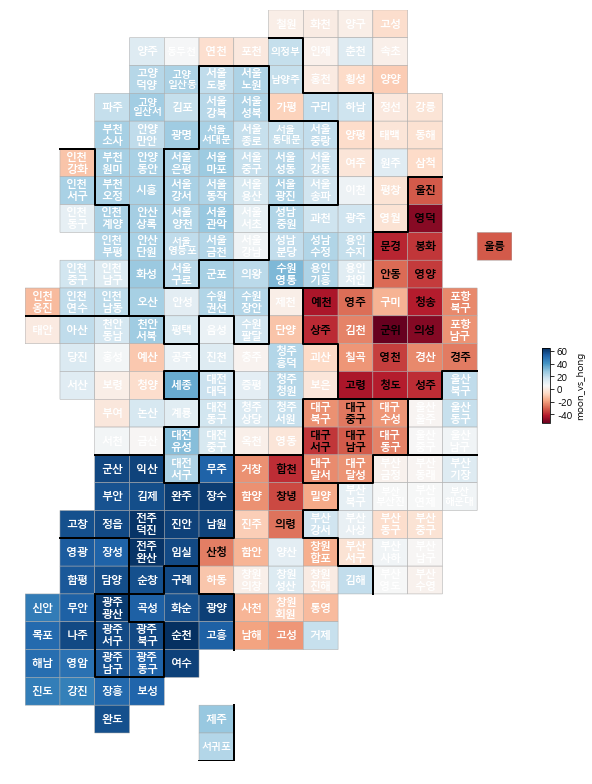

In [235]:
from draw_korea import drawKorea as dk
dk('moon_vs_hong', final_elect_data,  'RdBu')

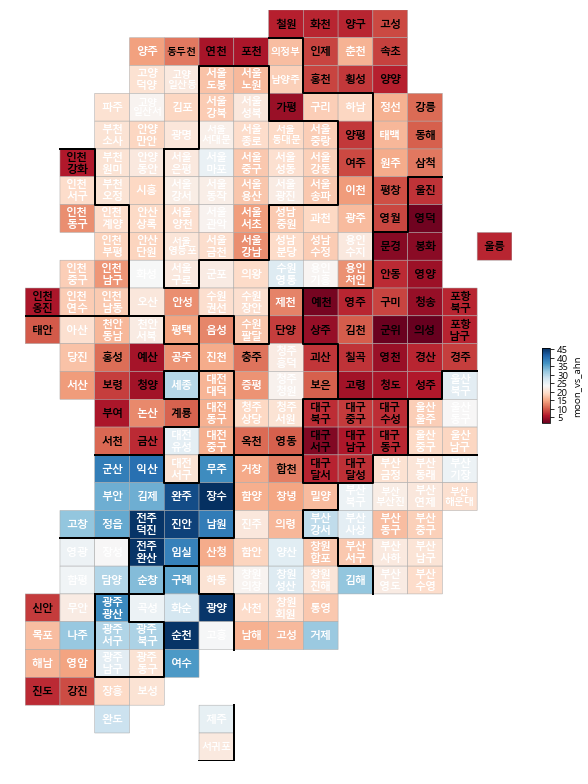

In [236]:
dk('moon_vs_ahn', final_elect_data,  'RdBu')

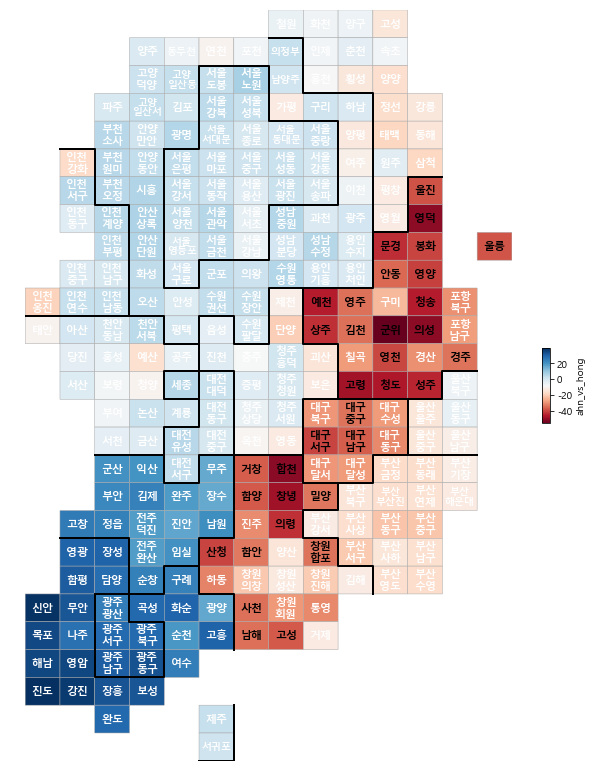

In [238]:
dk('ahn_vs_hong', final_elect_data,  'RdBu')